# Section 4.5 — Model selection

This notebook contains the code examples from [Section 4.5 Model selection]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/lm/modelselection"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import norm
from scipy.stats import binom
from scipy.stats import bernoulli

In [5]:
students = pd.read_csv("../datasets/students.csv")
students[["effort","score"]].mean(), students[["effort","score"]].std()

(effort     8.904667
 score     72.580000
 dtype: float64,
 effort    1.948156
 score     9.979279
 dtype: float64)

## Fork

### Example 1

In [6]:
from scipy.stats import norm

np.random.seed(41)
n = 200
ws = norm(0,1).rvs(n)
xs = 2*ws + norm(0,1).rvs(n)
ys = 0*xs + 3*ws + norm(0,1).rvs(n)

df1 = pd.DataFrame({
    "x": xs,
    "w": ws,
    "y": ys,
})

<Axes: xlabel='x', ylabel='y'>

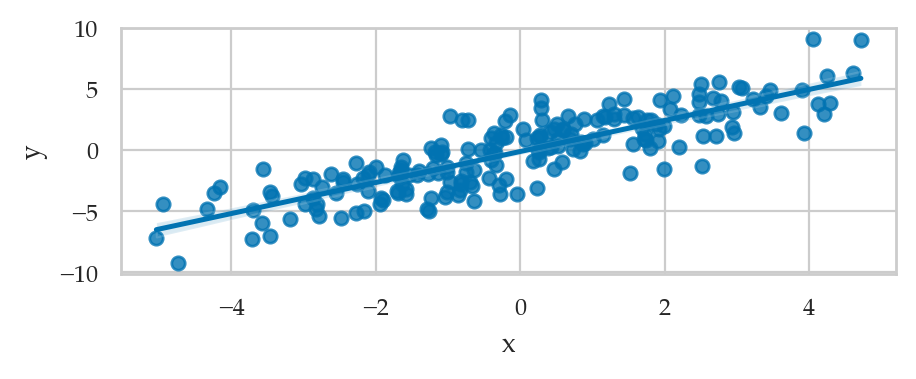

In [7]:
sns.regplot(x="x", y="y", data=df1)

In [8]:
lm1a = smf.ols("y ~ x", data=df1).fit()
lm1a.params

Intercept   -0.118596
x            1.268185
dtype: float64

In [9]:
lm1b = smf.ols("y ~ x + w", data=df1).fit()
lm1b.params

Intercept   -0.089337
x            0.077516
w            2.859363
dtype: float64

### Example 2


In [10]:
np.random.seed(43)
n = 100
mems = norm(5,1).rvs(n)
efforts = 20 - 3*mems + norm(0,1).rvs(n) 
scores = 10*mems + 2*efforts + norm(0,1).rvs(n)

# studentsmem ?
df2 = pd.DataFrame({
    "mem":mems,
    "effort": efforts,
    "score": scores
})

# df2.mean(), df2.std(), df2.max()

In [11]:
lm2a = smf.ols("score ~ effort", data=df2).fit()
lm2a.params

Intercept    64.275333
effort       -0.840428
dtype: float64

In [12]:
lm2b = smf.ols("score ~ effort + mem", data=df2).fit()
lm2b.params

Intercept    2.650981
effort       1.889825
mem          9.568862
dtype: float64

## Pipe

### Example 3

In [13]:
# X <- rnorm(N)
# Z <- rbern(N,inv_logit(X))
# Y <- rnorm(N,(2*Z-1))
# plot( X , Y , col=cols[Z+1] , lwd=3 )
# abline(lm(Y[Z==1]~X[Z==1]),col=2,lwd=3)
# abline(lm(Y[Z==0]~X[Z==0]),col=4,lwd=3)
# abline(lm(Y~X),lwd=3)


In [14]:
# FIXME
from scipy.stats import uniform, norm

np.random.seed(45)
n = 300
xs = uniform(0,1).rvs(n)
ms = xs > 0.7
ys = norm(2*ms-1,1).rvs(n)
zs = (xs + ys >= 1.7).astype(int)

df3 = pd.DataFrame({
    "x": xs,
    "m": ms,
    "y": ys,
})

<Axes: xlabel='x', ylabel='y'>

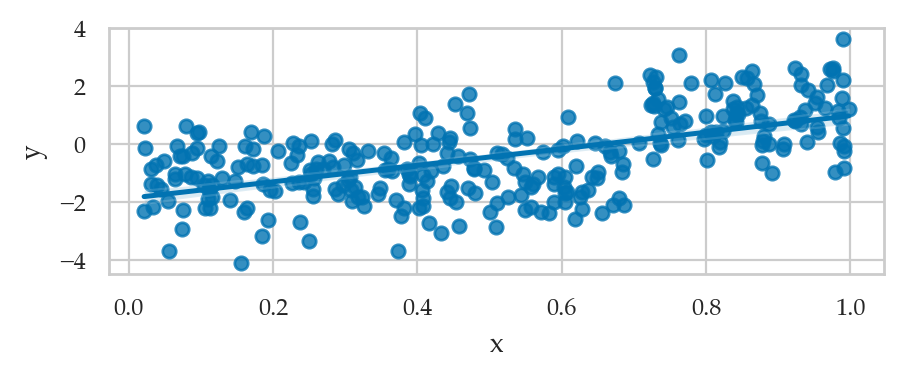

In [15]:
sns.regplot(x="x", y="y", data=df3)

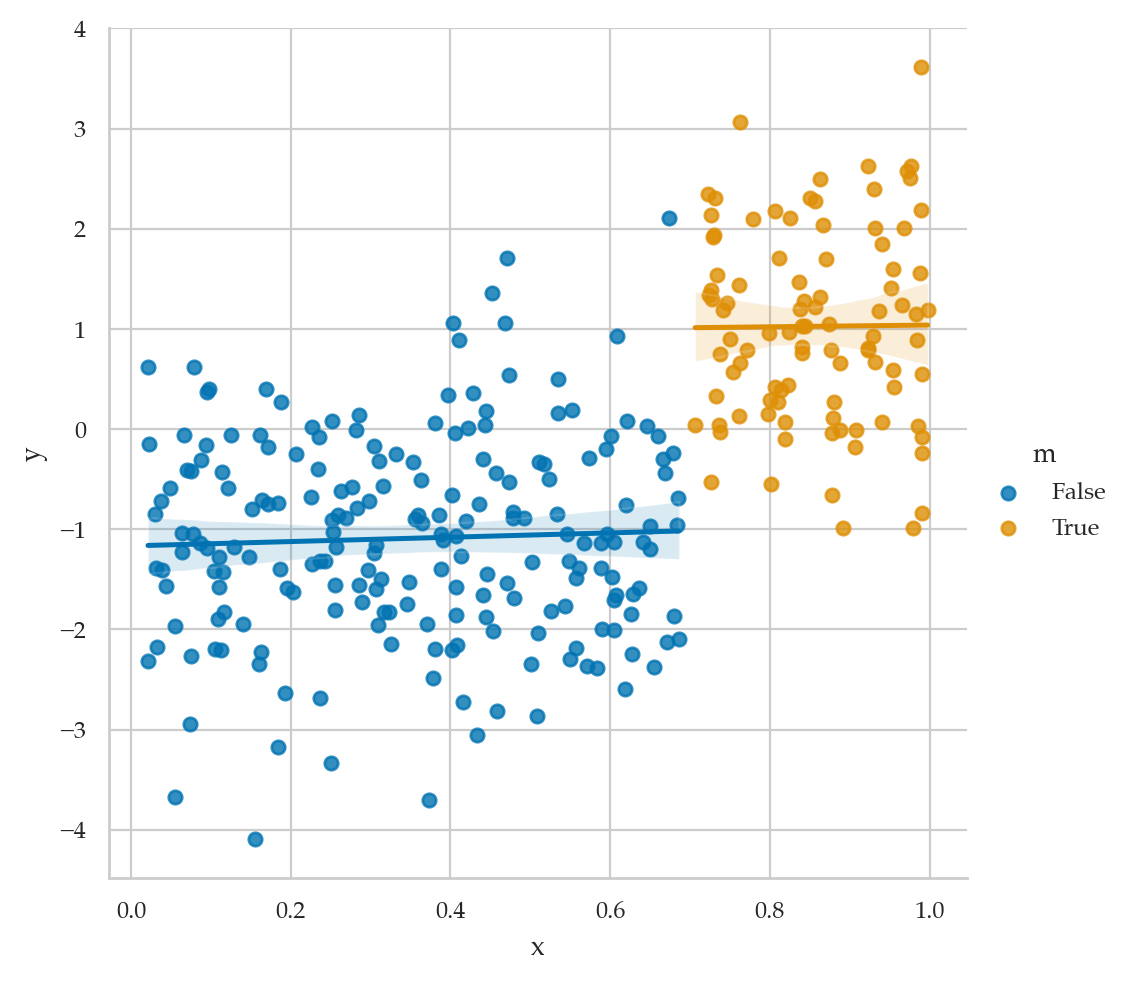

In [16]:
sns.lmplot(x="x", y="y", hue="m", data=df3)

### Example 4

Students' final `score`s as a function of `effort`.
We assume the final scores for the course was mediated through improvements in general competency  (`comp`).

In [17]:
np.random.seed(42)
n = 200
efforts = norm(9,2).rvs(n)
comps = 2*efforts + norm(0,1).rvs(n)
scores = 3*comps + norm(0,1).rvs(n)

# studentscmp ?
df4 = pd.DataFrame({
    "effort": efforts,
    "comp": comps,
    "score": scores,
})

The causal graph in this situation is an instance of the mediator pattern,
so the correct modelling decision is not to include the `comp` variable,
which allows us to recover the correct parameter.

In [18]:
lm4a = smf.ols("score ~ effort", data=df4).fit()
lm4a.params

Intercept   -0.538521
effort       6.079663
dtype: float64

However,
if we make the mistake of including the variable `comp` in the model,
we will obtain a zero parameter for the effort,
which is a wrong conclusion.

In [19]:
lm4b = smf.ols("score ~ effort + comp", data=df4).fit()
lm4b.params

Intercept    0.545934
effort      -0.030261
comp         2.979818
dtype: float64

## Collider

### Example 5

In [20]:
from scipy.stats import norm

np.random.seed(44)
n = 300
xs = norm(0,1).rvs(n)
ys = norm(0,1).rvs(n)
zs = (xs + ys >= 1.7).astype(int)

df5 = pd.DataFrame({
    "x": xs,
    "y": ys,
    "z": zs,
})

<Axes: xlabel='x', ylabel='y'>

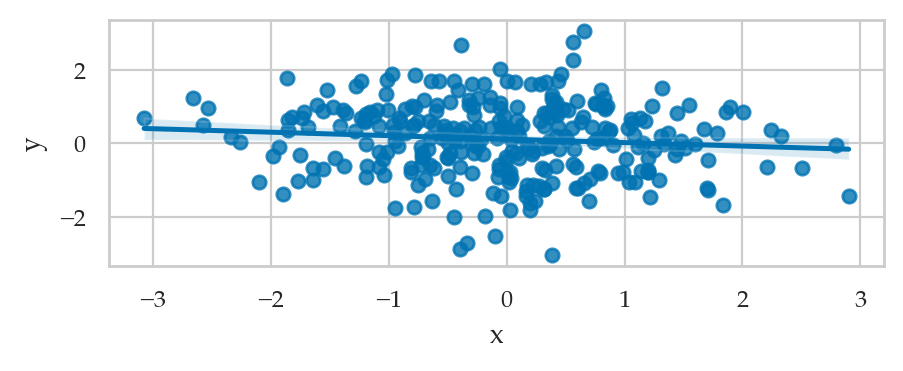

In [21]:
sns.regplot(x="x", y="y", data=df5)

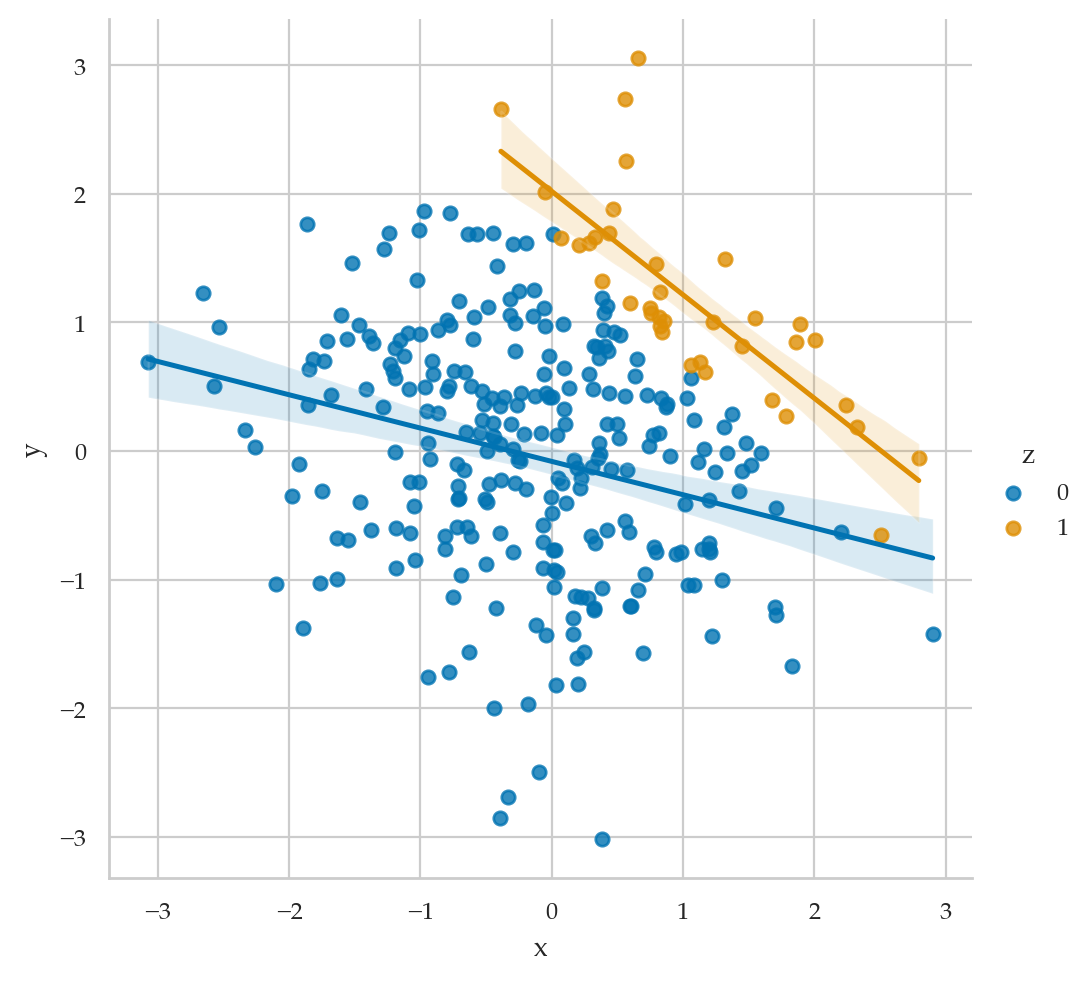

In [22]:
sns.lmplot(x="x", y="y", hue="z", data=df5)

### Example 6

In [23]:
np.random.seed(46)

n = 300
efforts = norm(9,2).rvs(n)
scores = 5*efforts + norm(10,10).rvs(n)
gpas = 0.1*efforts + 0.02*scores + norm(0.6,0.3).rvs(n)

# studentsgpa ?
df6 = pd.DataFrame({
    "effort": efforts,
    "score": scores,
    "gpa": gpas,
})

In [24]:
df6.mean(), df6.std(), df6.max()

(effort     8.980964
 score     55.110741
 gpa        2.590787
 dtype: float64,
 effort     1.930142
 score     14.016988
 gpa        0.561796
 dtype: float64,
 effort    13.978012
 score     96.287525
 gpa        4.643532
 dtype: float64)

When we don't adjust for the collider `gpa`,
we obtain the correct effect of effort on scores.

In [25]:
lm3a = smf.ols("score ~ effort", data=df6).fit()
lm3a.params

Intercept    12.747478
effort        4.717006
dtype: float64

But with adjustment for `gpa` reduces the effect significantly.

In [26]:
lm3b = smf.ols("score ~ effort + gpa", data=df6).fit()
lm3b.params

Intercept     1.464950
effort        1.177600
gpa          16.624215
dtype: float64

The false negative effect can also appear from sampling bias,
e.g. if we restrict our analysis only to people who were promoted.

## Selection bias

### Example 7: selection bias

In [27]:
df7 = df6[df6["gpa"]>3.4]
print(len(df7))
lm7 = smf.ols("score ~ effort", data=df7).fit()
lm7.params

23


Intercept    78.588495
effort       -0.126503
dtype: float64

## Benefits of random assignment

### Example 8

In [28]:
from scipy.stats import bernoulli
np.random.seed(47)

n = 300

mems = norm(5,1).rvs(n)
coins = bernoulli(p=0.5).rvs(n)
efforts = 5*coins + 15*(1-coins)
scores = 10*mems + 2*efforts + norm(0,1).rvs(n)

df8 = pd.DataFrame({
    "mem": mems,
    "effort": efforts,
    "score": scores,
})

In [29]:
# non-randomized              # with random assignment
df2.corr()["mem"]["effort"],  df8.corr()["mem"]["effort"]

(-0.9452404905554658, 0.037005646395469494)

In [30]:
df8.groupby("effort")["mem"].mean()

effort
5     4.958010
15    5.032875
Name: mem, dtype: float64

In [31]:
lm8a = smf.ols("score ~ effort", data=df8).fit()
lm8a.params

Intercept    49.176242
effort        2.077639
dtype: float64

In [32]:
lm8b = smf.ols("score ~ effort + mem", data=df8).fit()
lm8b.params

Intercept    -0.343982
effort        2.002295
mem          10.063906
dtype: float64

In [33]:
lm8c = smf.ols("score ~ mem", data=df8).fit()
lm8c.params

Intercept    17.382804
mem          10.430159
dtype: float64

## Variable selection

In [34]:
# load the dataset
doctors = pd.read_csv("../datasets/doctors.csv")

# fit the short model
formula2 = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula2, data=doctors).fit()

# fit long model with caffeine
formula2c = "score ~ 1 + alc + weed + exrc + caf"
lm2c = smf.ols(formula2c, data=doctors).fit()

# fit long model with useless varaible
formula2p = "score ~ 1 + alc + weed + exrc + permit"
lm2p = smf.ols(formula2p, data=doctors).fit()

### Comparing metrics

In [35]:
lm2.aic, lm2c.aic, lm2p.aic

(1103.2518084235273, 1092.066440497514, 1102.6030626936558)

In [36]:
lm2.bic, lm2c.bic, lm2p.bic

(1115.4512324525256, 1107.3157205337616, 1117.8523427299035)

In [37]:
lm2.fvalue, lm2c.fvalue, lm2p.fvalue

(270.34350189265825, 222.5179385249417, 205.51932993062275)

### F-test for the submodel

cf. https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.compare_f_test.html

In [38]:
F, p, _ = lm2c.compare_f_test(lm2)
F, p

(13.317646938672352, 0.0003615980907285796)

The $p$-value is smaller than $0.05$,
so we conclude that adding the variable `caf` improves the model.

In [39]:
F, p, _ = lm2p.compare_f_test(lm2)
F, p

(2.585739730738225, 0.10991892492566188)

The $p$-value is greater than $0.05$,
so we conclude that adding the variable `permit` doesn't improve the model.

### Likelihood ratio test

In [40]:
lm2c.compare_lr_test(lm2)

(13.185367926013441, 0.0002821434157606992, 1.0)

In [41]:
lm2p.compare_lr_test(lm2)

(2.648745729871507, 0.10363163447814171, 1.0)

### Lagrange multiplier test (optional)

In [42]:
# workaround to avoid bug
lm2_np = sm.OLS(lm2.model.endog, lm2.model.exog).fit()
lm2c_np = sm.OLS(lm2c.model.endog, lm2c.model.exog).fit()

# Lagrange Multiplier test to check short model
lm2c_np.compare_lm_test(lm2_np)

(12.643516756348614, 0.0003768703584529868, 1.0)

## Explanations

## Discussion

## Exercises

## Links

# CUT MATERIAL 

## Bonus examples

### Bonus example 1
Example 2 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [43]:
np.random.seed(1897)
n = 1000
iqs = norm(100,15).rvs(n)
ltimes = 200 - iqs + norm(0,1).rvs(n) 
tscores = 0.5*iqs + 0.1*ltimes + norm(0,1).rvs(n)

bdf2 = pd.DataFrame({
    "iq":iqs,
    "ltime": ltimes,
    "tscore": tscores
})

In [44]:
lm2a = smf.ols("tscore ~ ltime", data=bdf2).fit()
lm2a.params

Intercept    99.602100
ltime        -0.395873
dtype: float64

In [45]:
lm2b = smf.ols("tscore ~ ltime + iq", data=bdf2).fit()
lm2b.params

Intercept    3.580677
ltime        0.081681
iq           0.482373
dtype: float64

### Bonus example 2
Example 1 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [46]:
np.random.seed(1896)
n = 1000
learns = norm(0,1).rvs(n)
knows = 5*learns + norm(0,1).rvs(n)
undstds = 3*knows + norm(0,1).rvs(n)

bdf1 = pd.DataFrame({
    "learn":learns,
    "know": knows,
    "undstd": undstds
})

In [47]:
lm1a = smf.ols("undstd ~ learn", data=bdf1).fit()
lm1a.params

Intercept    -0.045587
learn        14.890022
dtype: float64

In [48]:
lm1b = smf.ols("undstd ~ learn + know", data=bdf1).fit()
lm1b.params

Intercept   -0.036520
learn        0.130609
know         2.975806
dtype: float64

### Bonus example 3
Example 3 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [49]:
np.random.seed(42)
n = 1000

ntwrks = norm(0,1).rvs(n)
comps = norm(0,1).rvs(n)
boths = ((ntwrks > 1) | (comps > 1))
lucks = bernoulli(0.05).rvs(n)
proms = (1 - lucks)*boths + lucks*(1 - boths)

bdf3 = pd.DataFrame({
    "ntwrk": ntwrks,
    "comp": comps,
    "prom": proms,
})

Without adjusting for the collider `prom`,
there is almost no effect of the network ability on competence.

In [50]:
lm3a = smf.ols("comp ~ ntwrk", data=bdf3).fit()
lm3a.params

Intercept    0.071632
ntwrk       -0.041152
dtype: float64

But with adjustment for `prom`,
there seems to be a negative effect.

In [51]:
lm3b = smf.ols("comp ~ ntwrk + prom", data=bdf3).fit()
lm3b.params

Intercept   -0.290081
ntwrk       -0.239975
prom         1.087964
dtype: float64

The false negative effect can also appear from sampling bias,
e.g. if we restrict our analysis only to people who were promoted.

In [52]:
df3proms = bdf3[bdf3["prom"]==1]
lm3c = smf.ols("comp ~ ntwrk", data=df3proms).fit()
lm3c.params

Intercept    0.898530
ntwrk       -0.426244
dtype: float64

### Bonus example 4: benefits of random assignment
Example 4 from [Why We Should Teach Causal Inference: Examples in Linear Regression With Simulated Data](https://www.tandfonline.com/doi/full/10.1080/10691898.2020.1752859)

In [53]:
np.random.seed(1896)
n = 1000

iqs = norm(100,15).rvs(n)
groups = bernoulli(p=0.5).rvs(n)
ltimes = 80*groups + 120*(1-groups)
tscores = 0.5*iqs + 0.1*ltimes + norm(0,1).rvs(n)

bdf4 = pd.DataFrame({
    "iq":iqs,
    "ltime": ltimes,
    "tscore": tscores
})

In [54]:
# non-randomized            # random assignment
bdf2.corr()["iq"]["ltime"],  bdf4.corr()["iq"]["ltime"]

(-0.9979264589333364, -0.020129851374243963)

In [55]:
bdf4.groupby("ltime")["iq"].mean()

ltime
80     99.980423
120    99.358152
Name: iq, dtype: float64

In [56]:
lm4a = smf.ols("tscore ~ ltime", data=bdf4).fit()
lm4a.params

Intercept    50.688293
ltime         0.091233
dtype: float64

In [57]:
lm4b = smf.ols("tscore ~ ltime + iq", data=bdf4).fit()
lm4b.params

Intercept   -0.303676
ltime        0.099069
iq           0.503749
dtype: float64

In [58]:
lm4c = smf.ols("tscore ~ iq", data=bdf4).fit()
lm4c.params

Intercept    9.896117
iq           0.501168
dtype: float64